# Bollinger Bands Strategy and Backtesting Report

******************************************************
**Prepared By : Samalie Piwan**  
**Andrew ID: spiwan**  
**Semester: Fall 2023**  
**Last modified: 2nd October 2023**  
******************************************************

## Strategy Implementation

In [3]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns

In [109]:
def bb_backtest_strategy(symbol, data_file, date_col, pricing_col, window, length, std):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        window:
            The number of days to use when computing the Simple Moving Average
        length:
            The short period, also used when calculating the SMA
        std:
            The long period
            
    Return
    -----------
        None
    
    """

    #Load the data from the downloaded file
    parent_df = pd.read_csv(data_file).dropna()
    
    main_df = parent_df[[date_col,pricing_col]].copy()

    #Convert the date column to datetime
    main_df[date_col] = pd.to_datetime(main_df[date_col])
    #Set the Date column as the index
    main_df_indexed = main_df.set_index(date_col)

    #Generate the bollinger bands
    #length (int): The short period. Default: 5
    #std (int): The long period. Default: 2
    #Function returns lower, mid, upper, bandwidth, and percent columns
    
    main_df_indexed.ta.bbands(close=pricing_col, length= length, std= std, append = True)

    #Create f strings for the column names
    str_upper_band = f"BBU_{length}_{std}.0"
    str_middle_band = f"BBM_{length}_{std}.0"
    str_lower_band = f"BBL_{length}_{std}.0"
    
    # Generate the trading signals
    # 1 Represents a buy
    # -1 represents a sell
    # 0 represents a hold
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        if(main_df_indexed[pricing_col][i-1] > main_df_indexed[str_lower_band][i-1] and main_df_indexed[pricing_col][i] < main_df_indexed[str_lower_band][i]):
            if(signal != 1):
                buy_price.append(main_df_indexed[pricing_col][i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(main_df_indexed[pricing_col][i-1] < main_df_indexed[str_upper_band][i-1] and main_df_indexed[pricing_col][i] > main_df_indexed[str_upper_band][i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(main_df_indexed[pricing_col][i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        if bands_signal[i] == 1:
            position[i] = 1
        elif bands_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Closing Price | SMA "+str(window))
    main_df_indexed[pricing_col].plot(label = 'Prices', color = 'skyblue')
    main_df_indexed[str_upper_band].plot(label = 'Upper Band '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    main_df_indexed[str_middle_band].plot(label = 'Middle Band '+str(window), linestyle = '--', linewidth = 1.2, color = 'grey')
    main_df_indexed[str_lower_band].plot(label = 'Lower Band '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    sns.scatterplot(x = main_df_indexed.index, y = sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    sns.scatterplot(x = main_df_indexed.index, y = buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Signal'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Position'] = position
    
    # Calculate Returns and Cummulative Returns and append to the DataFrame
    
    #New column name is LOGRET_1
    main_df_new.ta.log_return(close=pricing_col, append=True)
    
    #New column name is CUMLOGRET_1
    main_df_new.ta.log_return(close=pricing_col,cumulative=True, append=True)
    
    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Position'].shift(1) * main_df_new['LOGRET_1']
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum().apply(np.exp)
    
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Equity Lines | SMA "+str(window))
    plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()

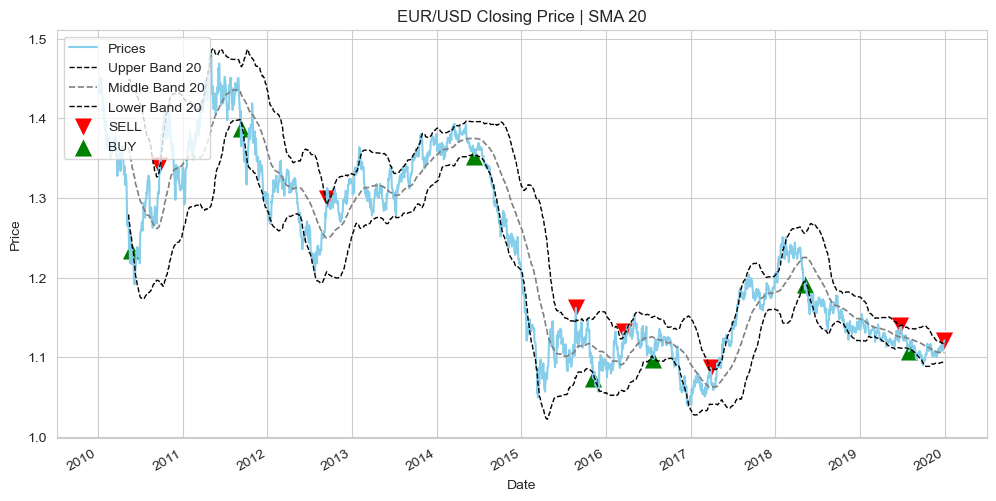

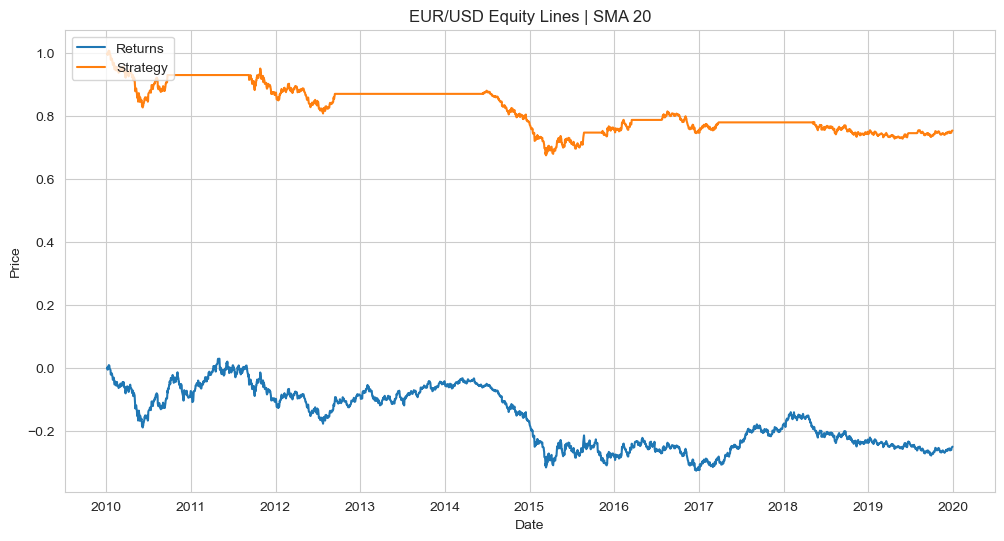

In [110]:
#window : The SMA window
#length (int): The short period. Default: 5
#std (int): The long period. Default: 2
bb_backtest_strategy('EUR/USD', 'pyalgo_eikon_eod_data.csv', 'Date', 'EUR=', window = 20, length = 90, std = 2)

### Parameter Sensitivity Analysis

For this strategy, we will focus on the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Short Period
- Long Period

In [86]:
#Import the backtesting library
from backtesting import Backtest, Strategy

In [94]:
#Load the data to be tested
df = pd.read_csv('SPY.csv').dropna()

#Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
#Set the Date column as the index
data_df = df.set_index('Date')

In [128]:
def indicator(data):
    bbands = ta.bbands(close = data.Close.s, std= 1)
    return bbands.to_numpy().T[:3]

In [138]:
class BollingerBandsStrategy(Strategy):
    
    def init(self):
        self.bbands = self.I(indicator, self.data)
        pass

    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] > lower_band[-1]:
                self.buy()

# Create an instance of the Backtest class and run the backtest

bt = Backtest(data_df, BollingerBandsStrategy, cash=5000, commission=0.001)
stats = bt.run()
print(stats)
bt.plot()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p2013', ...)